# Sensitivity to the dipole anisotropy

Method: take realistic noise, create fake anisotropy sky and see how much of the dipole we can actually detect

How can the noise on the anisotropy map be tamed by the threshold?

Some other crazy ideas tested to reduce the noise:
- "Dynamic radius" smoothing: for each pixel take the smoothing tophat radius that reduces the smoothed pixel amplitude. Doesn't really do the thing.
- "Dynamic" threshold -- complete stupidity. Tried to vary the threshold as function of the reconstructed dipole. Supposed to be an iterative procedure. Either kills the true dipole, or increase the fake fluctuations.
- Image-processing-like filtering: detect the noisy pixels by looking at the surrounding ones. Doesn't really work.

Why bother about the noise? The question may seem dumb, but remember that actually we have NO NOISE in the experiment. Every event we have is a signal.

However, the counts in pixels can fluctuate and eventually create a strong excess or deficite. This may prevent us from measuring some particular property of the signal -- the anisotropy. After several tries I found that setting a 1.5$\sigma$ threshold on the anisotropy signal allows to significantly lower the null-hypothesis expectations (hence, lower the upper limits), while leaving the true signal the same.

In [14]:
from __future__ import division
import numpy as np
import healpy as hp  # need version 1.12.5 or higher
import matplotlib.pyplot as mp
from scipy.integrate import quad
from scipy.optimize import fsolve, curve_fit
from ipywidgets import FloatProgress
from IPython.display import display
import os
import pickle
import numbers
from tools import *

Take the real isotropy and observation map. Both are produced by Maria, and both are in galactic coordinates with nside=16. We upgrade the nside and rotate the maps to the equatorial coordinates

In [15]:
iso_map = np.load('iso_map.npy')
nside = hp.npix2nside(len(iso_map))
print("Number of events - {}".format(iso_map.sum()))

Number of events - 403802.0


In [16]:
r = hp.rotator.Rotator(coord='GC')
# Optional parameter power=-2 allows to keep the integral of the map unchanged
iso_map = hp.ud_grade(iso_map, 32, power=-2)
iso_map = r.rotate_map_alms(iso_map)
iso_map = hp.ud_grade(iso_map, nside, power=-2)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


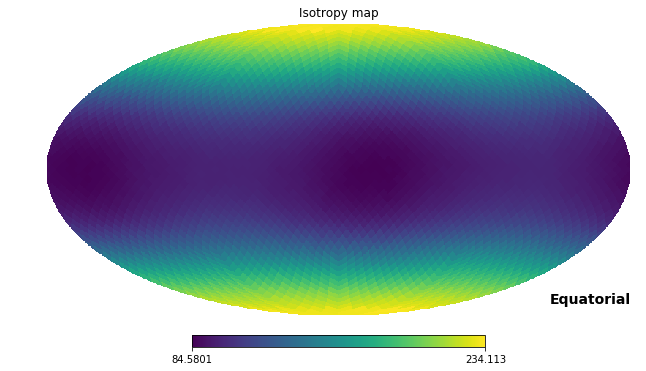

In [17]:
hp.mollview(iso_map, coord='C', title='Isotropy map')

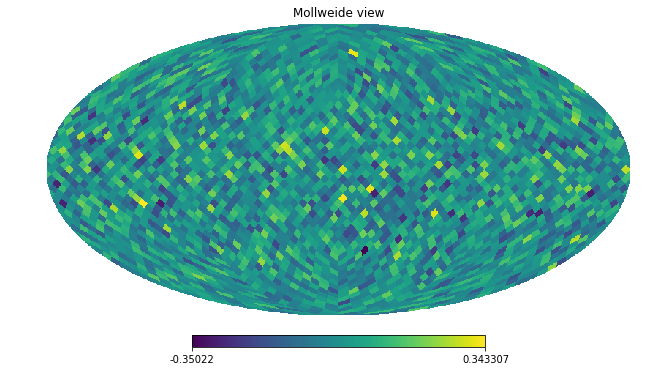

In [5]:
hp.mollview(create_noise_map(iso_map))

In [6]:
dipole_ampl = 0.  # 0.01
dipole_dir = None  # (90, 0)

In [7]:
ani_model = create_dipole_map(nside, dipole_ampl, dipole_dir) + create_noise_map(iso_map)

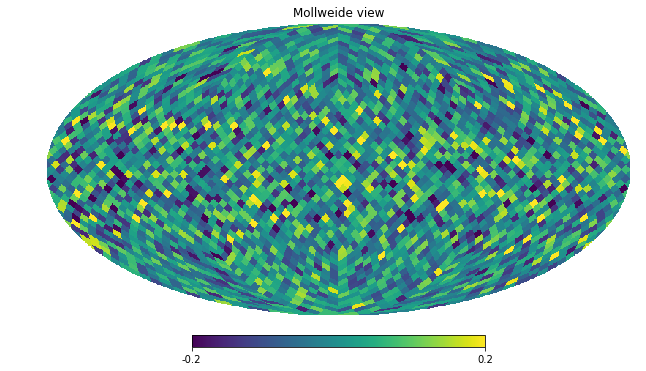

In [8]:
hp.mollview(ani_model, min=-0.2, max=0.2)

Set threshold!

In [24]:
smoothed_nothr, npix_nothr = tophat_smoothing(ani_model, 90.)

FloatProgress(value=0.0, max=3072.0)

In [25]:
ani_model_thr = cut_on_thr(ani_model, iso_map, 1.5)
smoothed_thr, npix_thr = tophat_smoothing(ani_model_thr, 90.)

FloatProgress(value=0.0, max=3072.0)

Reconstructed/input dipole amplitude, no threshold = 0.0089/0.0000
Reconstructed/input dipole amplitude, threshold = 0.0079/0.0000


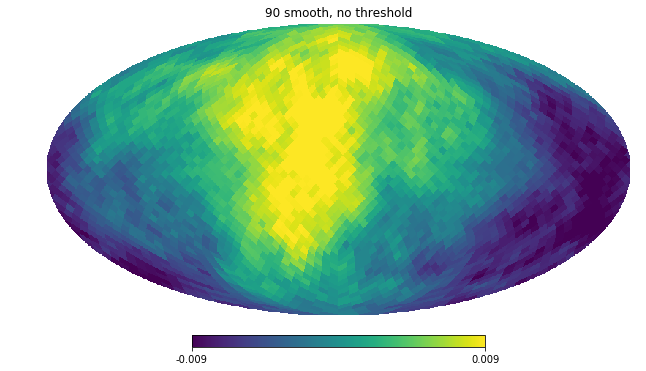

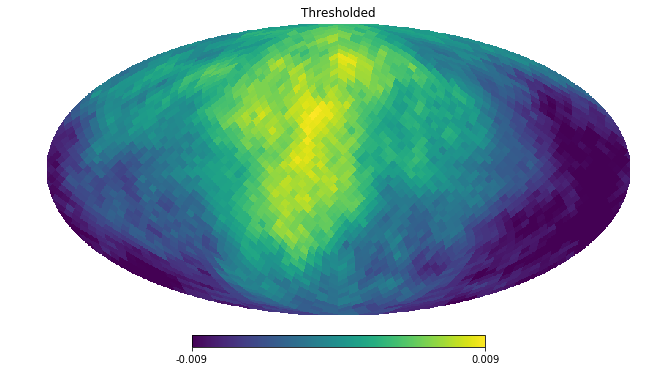

In [26]:
drec = get_dipole_ampl(smoothed_nothr)
fac = 1.0
minmax = np.round(fac * drec, 3)
hp.mollview(smoothed_nothr, title='90 smooth, no threshold',
            min=-minmax, max=minmax)
hp.mollview(smoothed_thr, title='Thresholded',
            min=-minmax, max=minmax)
print('Reconstructed/input dipole amplitude, no threshold = {:.4f}/{:.4f}'.
      format(drec, dipole_ampl))
drec = get_dipole_ampl(smoothed_thr)
print('Reconstructed/input dipole amplitude, threshold = {:.4f}/{:.4f}'.
      format(drec, dipole_ampl))

### Significance

Significance for each pixel of the smoothed map is

$\sqrt{{N_{obs} N_{pix}}\over {1 + \alpha}} \delta I$

where $N_{obs}$ is the number of observations in this pixel (iso_map) and $N_{pix}$ is the number of pixels over which we were taking the mean

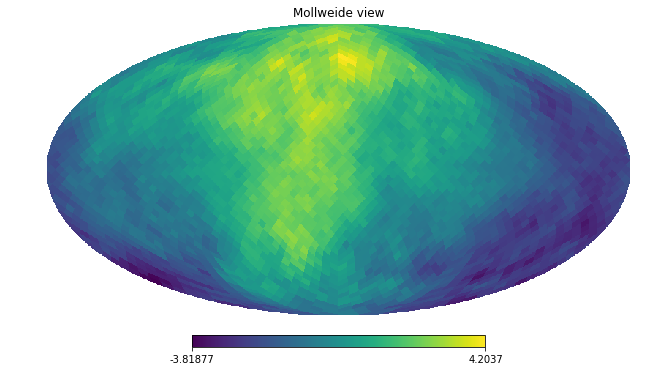

In [27]:
sig_map = get_sig_map(smoothed_nothr, iso_map, 1, npix_nothr)
hp.mollview(sig_map)

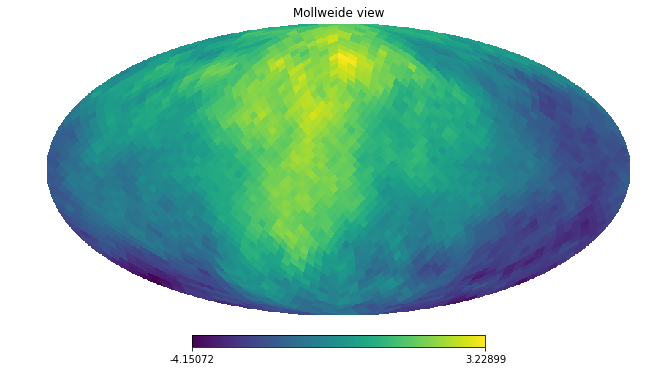

In [38]:
sig_map = get_sig_map(smoothed_thr, iso_map, 1, npix_thr)
hp.mollview(sig_map)

In [39]:
def g(x, m, s):
    return np.exp(-0.5 * ((x - m) / s)**2) / np.sqrt(2 * np.pi) / s

i = quad(lambda x: g(x, 0., 1.), -3., 3.)[0]
i = 1 - i

pc = (np.abs(sig_map) > 3).sum() / hp.nside2npix(nside)

print 'There might be about {:.2f}% of pixels with |S| > 3'.format(i * 100)
print 'We measure {:.2f}% of such pixels'.format(pc * 100)

There might be about 0.27% of pixels with |S| > 3
We measure 2.73% of such pixels


I am not sure, but maybe the result in the cell above means that there is a little sence in doing the tophat smoothing. In fact, it doesn't increase the sensitivity. It is only useful for the presentation purposes, once the detection is confirmed.

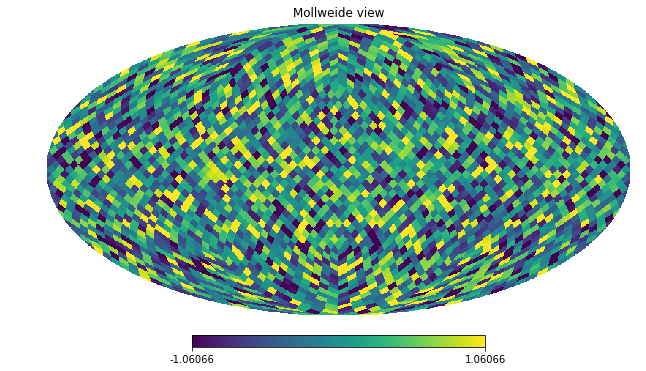

In [36]:
sig_map = get_sig_map(ani_model_thr, iso_map, 1)
hp.mollview(sig_map)

## In order to get the sensitivity, run many realisations

To make things faster, reduce the nside

In [18]:
nside = 4
iso_map = hp.ud_grade(iso_map, nside, power=-2)

In [19]:
def one_realisation(dipole_ampl, dipole_dir, iso_map):
    '''
    Run one realisation of the sky,
        smooth it on 90 deg
        and then estimate the dipole
    Return reconstructed dipole amplitude
        and the distance of the reconstructed dipole vector
        from the original one.
        If the input dipole_ampl == 0,
        then retrun the reconstructed amplitude
        and the declination of the reconstructed dipole
    '''
    nside = hp.npix2nside(len(iso_map))
    ani_model = create_dipole_map(nside, dipole_ampl, dipole_dir)
    if dipole_dir is None:
        orig_dir = get_dipole_dir(ani_model)
    elif dipole_ampl == 0:
        orig_dir = (0., 0.)
    else:
        orig_dir = dipole_dir
    ani_model += create_noise_map(iso_map)
    
    ani_model = cut_on_thr(ani_model, iso_map, 1.5)    
#     smoothed, npix = tophat_smoothing(ani_model, 90., progress=False, 
#                                       ring_filter=20., ring_const=0.8)
    
#     rec_ampl = get_dipole_ampl(smoothed)
#     rec_dir = get_dipole_dir(smoothed)
#     rec_ampl = get_dipole_ampl(ani_model)
    rec_dir = get_dipole_dir(ani_model)
    
    # Estimate the noise C_N (see 1903.02905)
    C_ell = hp.anafast(ani_model)[1]
    obs_map = (ani_model + 1) * iso_map
    C_N = 0. #4. * np.pi / len(iso_map)**2 * (obs_map / iso_map**2).sum()
#     C_N /= 1.35**2
    rec_ampl = 3 * np.sqrt((C_ell - C_N) / 4 / np.pi)
    
    if dipole_ampl == 0:
        dist = rec_dir[1]
    else:
        dist = np.degrees(hp.rotator.angdist(orig_dir, 
                                             rec_dir, lonlat=True))[0]
    return rec_ampl, dist

In [7]:
N = 5000 # number of realisation for each set of input parameters

# dipole_ampl = 1e-2
# dipole_dir = (90, 0)
dipole_ampl = 0.
dipole_dir = None

f = FloatProgress(min=0, max=N)
display(f)

ampl = np.empty(N)
d = np.empty(N)

for i in xrange(N):
    a = np.nan
    while not np.isfinite(a):
        a, d[i] = one_realisation(dipole_ampl, 
                                  dipole_dir, 
                                  iso_map)
    ampl[i] = a
    f.value += 1
    
d = d[np.isfinite(ampl)]
ampl = ampl[np.isfinite(ampl)]

FloatProgress(value=0.0, max=5000.0)

/Users/stolpovs/anaconda2/lib/python2.7/site-packages/healpy/pixelfunc.py:751: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(vectors[:, 2] / dnorm)


Use this if you were running the $\delta \neq 0$ simulations

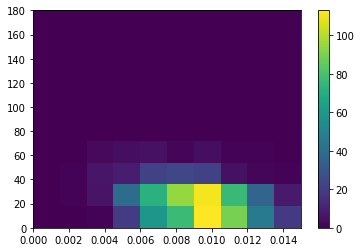

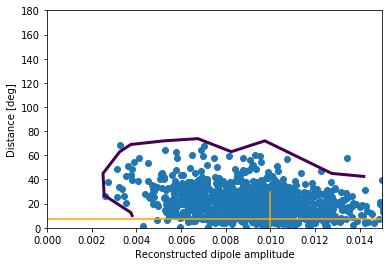

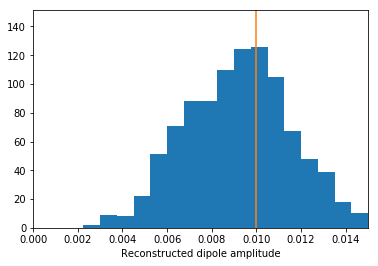

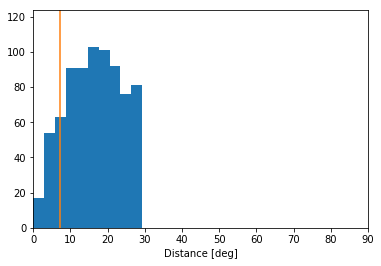

Dipole amplitude reconstruced = 0.0093 +- 0.0025


In [20]:
reso = np.degrees(hp.nside2resol(nside))
xlim = 0.015 #dipole_ampl * 2.
ylim = reso * 4.
counts, xbins, ybins, image = mp.hist2d(ampl, d, bins=[10, 10], 
                                        range=[[0., xlim], #5*xlim], 
                                               [0., 180.]])
mp.colorbar()
mp.show()

mp.scatter(ampl, d)
xbw = (xbins[1] - xbins[0]) / 2.
ybw = (ybins[1] - ybins[0]) / 2.
mp.contour(xbins[:-1] + xbw, ybins[:-1] + ybw, counts.T,  
           extent=[xbins.min(), xbins.max(),
                   ybins.min(), ybins.max()], 
           linewidths=3,
           levels=2) #[N*0.6826, N*0.9544])
mp.plot([dipole_ampl, dipole_ampl], [0., ylim], c='orange')
mp.plot([0., xlim], [reso, reso], c='orange')
mp.xlabel('Reconstructed dipole amplitude')
mp.ylabel('Distance [deg]')
mp.xlim(0., xlim)
mp.ylim(0., 180.)# ylim)
mp.show()

n, bins, patches = mp.hist(ampl, 20, range=(0., xlim))
mp.plot([dipole_ampl, dipole_ampl], [0., 200.])
mp.xlabel('Reconstructed dipole amplitude')
mp.ylim(0., n.max() * 1.2)
mp.xlim(0., xlim)
mp.show()

n, bins, patches = mp.hist(d, 10, range=(0., ylim))
mp.plot([reso, reso], [0., 200.])
mp.xlabel('Distance [deg]')
mp.ylim(0., n.max() * 1.2)
mp.xlim(0., 90.)
mp.show()

print('Dipole amplitude reconstruced = {:.4f} +- {:.4f}'.\
      format(ampl.mean(), ampl.std()))

And use this code, if that were the $\delta = 0$ simulations!

95% C.L. upper limit = 0.00720189721458


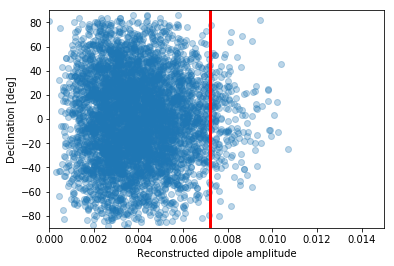

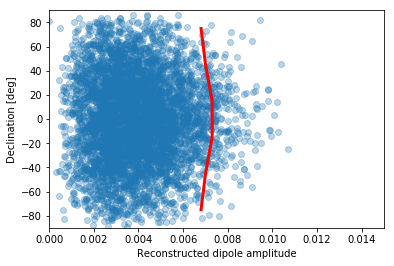

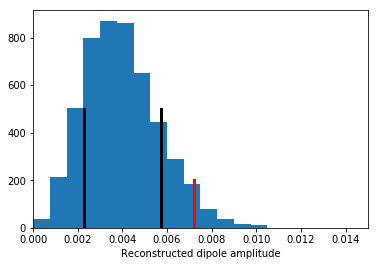

In [10]:
xlim = 0.015
mp.scatter(ampl, d, alpha=0.3)
lim = UpperLimit(ampl).get_upper_limit()
print('95% C.L. upper limit = {}'.format(lim))
mp.plot([lim, lim], [-90., 90.], c='r', lw=3)
mp.xlabel('Reconstructed dipole amplitude')
mp.ylabel('Declination [deg]')
mp.xlim(0., xlim)
mp.ylim(-90., 90.)
mp.show()

mp.scatter(ampl, d, alpha=0.3)
dec_ar = np.array([75, 45, 15, -15, -45, -75])
dec_bw = 30
ul_temp = np.empty(len(dec_ar))
for k, dec in enumerate(dec_ar[:3]):
    mask = np.abs(np.abs(d) - dec) < dec_bw / 2.
    ul_obj = UpperLimit(ampl[mask])
    ul_temp[k] = ul_obj.get_upper_limit()
ul_temp[3:] = ul_temp[:3][::-1]
mp.plot(ul_temp, dec_ar, lw=3, c='r')
mp.xlabel('Reconstructed dipole amplitude')
mp.ylabel('Declination [deg]')
mp.xlim(0., xlim)
mp.ylim(-90., 90.)# ylim)
mp.show()

n, bins, patches = mp.hist(ampl, 20, range=(0., xlim))

bw = (bins[1] - bins[0])
x = bins[1:] - bw / 2
mp.plot([lim, lim], [0., 200.], lw=3, c='r')
nhlim = UpperLimit(ampl).get_nhlimits()
mp.plot([nhlim[0], nhlim[0]], [0., 500.], lw=3, c='k')
mp.plot([nhlim[1], nhlim[1]], [0., 500.], lw=3, c='k')
mp.xlabel('Reconstructed dipole amplitude')
mp.xlim(0., xlim)
mp.show()

If you measure some inconclusive dipole amplitude, let's say $3.9 \cdot 10^{-4}$, the "experiment" upper limit will be:

In [12]:
UpperLimit.get_experimental_ul(3.9e-4, cl=0.95)

0.0011395312499999995

Why I didn't get the exact same result as Fermi guys? (Recall they got $1.3 \cdot 10^{-3}$). They actually use a slightly different method. They use the "frequentist" approach, while this one is Bayesian. Both are explained in the supplemental materials to the Fermi paper "Search for Cosmic-Ray Electron and Positron Anisotropies with Seven Years of Fermi Large Area Telescope Data": https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.118.091103

### Dipole upper limit
The dipole upper limit is defined by the probability to observe some dipole amplitude while actually there is no anisotropy in the sky (Null hypothesis). Thus there could not be any dependence on the declination. 

In [20]:
E_ar = np.array([100., 250., 500., 1000.])
stat = np.array([15521572, 2954456, 927621, iso_map.sum()])

In [21]:
dec_bw = 30.
dec_ar = np.arange(-90., 90, dec_bw) + dec_bw / 2.

In [24]:
N = 10000
dipole_ampl = 0

f = FloatProgress(min=0, max=N * len(E_ar))
display(f)

# dipole upper limit independent of declination
ul = np.empty(len(E_ar))
# dipole upper limit as fun of E and dec
ul_dec = np.empty((len(E_ar), len(dec_ar)))

for j, e in enumerate(E_ar):
    iso_map_scaled = iso_map / iso_map.sum()
    iso_map_scaled *= stat[j:].sum()

    ampl = np.empty(N)
    dec = np.empty(N)

    for i in xrange(N):
        a = np.nan
        while not np.isfinite(a):
            a, dec[i] = one_realisation(dipole_ampl, 
                                        None, 
                                        iso_map_scaled)
        ampl[i] = a
        f.value += 1
        
    ind = int(len(dec_ar) / 2)
    for k, d in enumerate(dec_ar[:ind]):
        mask = np.abs(np.abs(dec) - np.abs(d)) < dec_bw / 2.
        ul_obj = UpperLimit(ampl[mask])
        ul_dec[j][k] = ul_obj.get_upper_limit()
    ul_dec[j][ind:] = ul_dec[j][:ind][::-1]
        
    ul_obj = UpperLimit(ampl)
    ul[j] = ul_obj.get_upper_limit()

FloatProgress(value=0.0, max=40000.0)

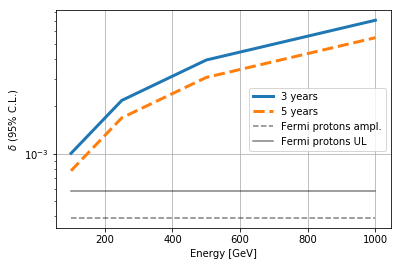

In [26]:
mp.semilogy(E_ar, ul, lw=3, label='3 years')
ul5 = ul / (5 / 3)**0.5
mp.plot(E_ar, ul5, '--', lw=3, label='5 years')
mp.plot([100, 1000], [3.9e-4, 3.9e-4],
        'k--', alpha=0.5, label='Fermi protons ampl.')
# mp.plot([100, 1000], [1.3e-3, 1.3e-3],
#         'k-', alpha=0.5, label='Fermi protons UL')
mp.plot([100, 1000], [5.8e-4, 5.8e-4],
        'k-', alpha=0.5, label='Fermi protons UL')

mp.legend()
mp.grid()
mp.xlabel('Energy [GeV]')
mp.ylabel('$\delta$ (95% C.L.)')
mp.show()

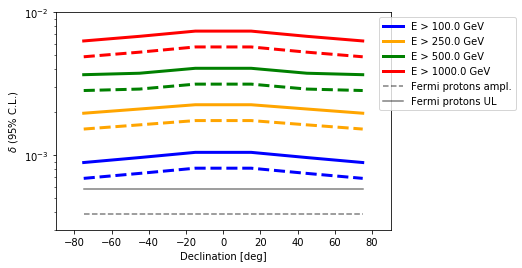

In [28]:
color = ['blue', 'orange', 'green', 'red']
for i, e in enumerate(E_ar):
    mp.semilogy(dec_ar, ul_dec[i], 
                lw=3, color=color[i], 
                label='E > {} GeV'.format(e))
    mp.plot(dec_ar, ul_dec[i] / (5 / 3)**0.5, 
            '--', lw=3, color=color[i])
mp.plot(dec_ar, np.ones(len(dec_ar)) * 3.9e-4,
        'k--', alpha=0.5, label='Fermi protons ampl.')
# mp.plot(dec_ar, np.ones(len(dec_ar)) * 1.3e-3,
#         'k-', alpha=0.5, label='Fermi protons UL')
mp.plot(dec_ar, np.ones(len(dec_ar)) * 5.8e-4,
        'k-', alpha=0.5, label='Fermi protons UL')
mp.legend(bbox_to_anchor=(0.95, 1.))
mp.xlabel('Declination [deg]')
mp.ylabel('$\delta$ (95% C.L.)')
mp.xlim(-90, 90)
mp.ylim(3e-4, 1e-2)
mp.show()